# Approximate a mixture of Gaussians

This notebook recreates the mixture-of-Gaussians benchmarking experiments in the main paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
sys.path.insert(0, '../src')
from scipy import stats
#import rff, subsample, herding
%matplotlib inline

First, we define the synthetic target distribution in the following class.

In [3]:
class SyntheticTarget(object):
    
    def __init__(self, dist_components=2, dim=2, seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.dist_weights = stats.dirichlet(np.ones(dist_components)*10).rvs().ravel()
        dist_centers = np.random.uniform(-4, 4, size=(dist_components, dim))

        def gen_cov():
            assert(dim == 2)
            rho = np.random.rand()-0.5
            sd = np.random.rand(dim)*0.4+0.5
            L = np.zeros((dim,dim))
            L[0,0] = sd[0]**2
            L[1,1] = sd[1]**2
            L[0,1] = rho*sd.prod()
            return np.dot(L, L.T)

        dist_cov = np.array([gen_cov() for i in xrange(dist_components)])
        self.dist_obj = np.array([stats.multivariate_normal(dist_centers[k], dist_cov[k]) for k in xrange(dist_components)], dtype=object)
        self.dim = dim

    def compute_pdf(self, x):
        return np.sum(self.dist_weights[:,None,None] * np.array([d.pdf(x) for d in self.dist_obj]), 0)

    def draw_sample(self, ns=1):
        component = np.random.multinomial(ns, self.dist_weights) # np.argmin(np.random.rand() > self.dist_weights.cumsum())
        offset = np.concatenate(([0], component.cumsum()[:-1]))
        samples = np.empty((ns,self.dim))
        for c, n in enumerate(component):
            if n > 0:
                samples[offset[c]:offset[c]+n] = self.dist_obj[c].rvs(n) 
        np.random.shuffle(samples)
        return samples

    def draw_sample_slow(self):
        component = np.argmin(np.random.rand() > self.dist_weights.cumsum())
        return self.dist_obj[component].rvs()

    def plot(self):
        delta = 0.1
        boundary = 5
        x = np.arange(-boundary, boundary, delta)
        y = np.arange(-boundary, boundary, delta)
        X, Y = np.meshgrid(x, y)
        Z = np.log(self.compute_pdf(np.concatenate((X[:,:,None],Y[:,:,None]),2)))
        plt.figure()
        contour_levels = np.arange(-9,1)
        CS = plt.contour(X, Y, Z, levels=contour_levels)
        plt.set_cmap('Blues')

In [4]:
# Change for different sampled target dist
SEED = 666
ex = SyntheticTarget(seed=SEED, dist_components=2)

In [9]:
sample_size = 100000
M = 100
stream = ex.draw_sample(sample_size)
#stream.shape finds the dimensions of the nparray stream
print stream.shape, "=>", M

(1000, 2) => 100


## The target distribution, and some random samples

We will summarize a very large number of samples from this distribution with a smaller number of optimized points.

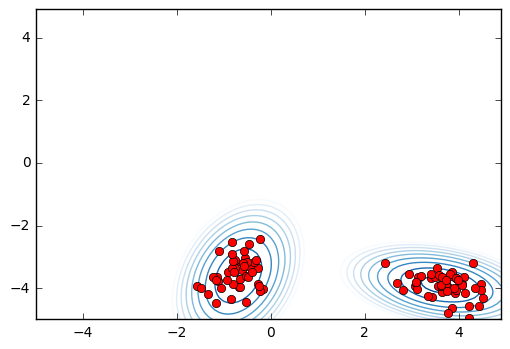

In [10]:
ex.plot()
plt.plot(stream[:M,0], stream[:M,1], 'ro');

We will evaluate a set of candidate points based on how well they perform on a small set of test functions.

The online algorithm will be compared to two benchmarks:

(1) `full_stream_result`, using a batch algorithm on the same large set of points  
(2) `true_result`, using a batch algorithm on a much larger set of points

In [6]:
f1 = lambda x: x
f2 = lambda x: (x**2)
f3 = lambda x: (x**3)
f4 = lambda x: np.sin(np.sqrt(np.sum(x**2, 1, keepdims=True)))

fns = [f1, f2, f3, f4]
fn_labels = ['$x$', '$x^2$', '$x^3$', '$\mathrm{sin}(||x||)$']

def E(fn, x, w=None): 
    if w is not None:
        return np.dot(w, fn(x))
    else:
        return np.mean(fn(x),0)

print "Batch benchmark"
full_stream_result = []
for i, fn in enumerate(fns):
    val = E(fn, stream)
    print "E[f_%d] approx" % i, val
    full_stream_result.append(val)

benchmark_stream = ex.draw_sample(S*100)
print "\nGround truth benchmark"
true_result = []
for i in xrange(len(fns)):
    true_result.append(E(fns[i], np.array(benchmark_stream, copy=False)))
    print "E[f_%d] =" % i, true_result[i]

Batch benchmark
E[f_0] approx [ 0.61231841 -0.2313324 ]
E[f_1] approx [ 5.06081667  5.1486025 ]
E[f_2] approx [ 6.85896092  1.33510655]
E[f_3] approx [ 0.15134867]

Ground truth benchmark
E[f_0] = [ 0.60911552 -0.22066012]
E[f_1] = [ 5.03598777  5.18483058]
E[f_2] = [ 6.93367203  1.49760828]
E[f_3] = [ 0.15313419]


## Define a feature space and run the subsampler

We run the tree subsampler here while logging, and while benchmarking against an exact nearest neighbor search, so the runtime will be very poor. If `benchmark=False` and `logging=False`, then the runtime will be logarithmic (instead of linear) in `M`.

In [7]:
phi = rff.RFF(500, 2, lengthscale=rff.median_heuristic(stream[:M]))

In [8]:
# Seed with the first M points
initial_points = np.array(stream[:M])

# Compute batch benchmark feature mean
full_stream_phi = phi(stream).mean(0)
full_stream_sq_norm = np.sum(full_stream_phi**2,0)

subsampler = subsample.TreeSubsampler(initial_points, phi, 
                                      benchmark=True, 
                                      logging=True, 
                                      ground_truth_phi=full_stream_phi,
                                      test_fns=fns)

for i in xrange(2M, len(stream)):
    if np.mod(i, 5000) == 1:
        print i-1
    subsampler.consider(stream[i])


Size of subsample: 100
Number of items: 100
Each item dimension: 500
Tree depth: 3
Expected number of points at leaf: 12.5
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000


Plot the sampled points

empirical MMD online (tree search): 0.000566241352567
||u||^2 = 0.5999, ||v||^2 = 0.5999, 2<u,v> = 1.1998


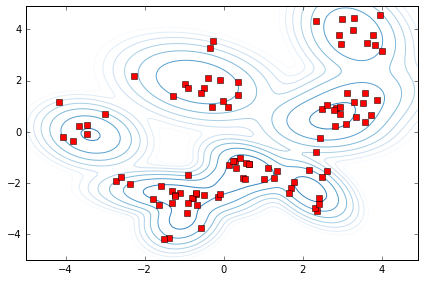

In [9]:
ex.plot()
plt.plot(subsampler.points[:,0], subsampler.points[:,1], 'rs')



subsampled_features = np.mean(phi(np.array(subsampler.points)),0)
subsampled_norm = np.dot(subsampled_features, subsampled_features)
empirical_MMD_online = np.sqrt(full_stream_sq_norm + subsampled_norm - 2*np.dot(subsampled_features, full_stream_phi))
print "empirical MMD online (tree search):", empirical_MMD_online
print "||u||^2 = %0.4f, ||v||^2 = %0.4f, 2<u,v> = %0.4f" % (full_stream_sq_norm, subsampled_norm, 2*np.dot(subsampled_features, full_stream_phi))

plt.tight_layout();

How much time do we save in the nearest neighbor search by using the random projection tree?

average comparisons: 15.3966166166 of 100
median comparisons: 15.0 of 100


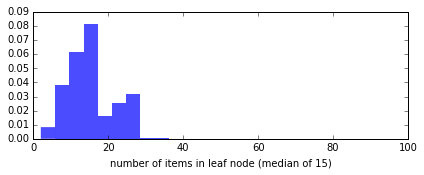

In [10]:
print "average comparisons:", np.mean(subsampler.counts), "of", M
print "median comparisons:", np.median(subsampler.counts), "of", M


plt.figure(figsize=(6, 2.5))
plt.xlim([0,M])
plt.hist(subsampler.counts, linewidth=0.0, alpha=0.7, normed=True);
plt.xlabel('number of items in leaf node (median of %d)' % (np.median(subsampler.counts)))
plt.tight_layout();

In [11]:
print "Made best overall decision %0.2f%% of the time" % (100*np.mean(1.0*np.array(subsampler.found_best)))

Made best overall decision 97.96% of the time


In [12]:
print "Accepted in %0.2f%% of opportunities" % (100.0*float(np.array(subsampler.accepted).sum()) / np.array(subsampler.could_have_accepted).sum())

Accepted in 64.28% of opportunities


## Benchmark against linear scan

What do we lose, relative to running a full search each iteration?

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
empirical MMD online (linear scan): 0.000312036284346
||u||^2 = 0.5999, ||v||^2 = 0.6000, 2<u,v> = 1.1999


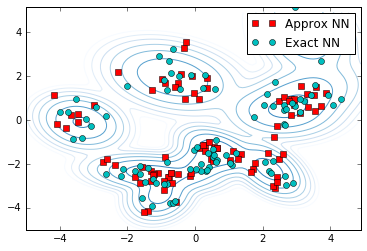

In [13]:
safe_subsampler = subsample.LinearSubsampler(initial_points, phi, 
                                             logging=True, 
                                             ground_truth_phi=full_stream_phi,
                                             test_fns=fns)

for i in xrange(M, len(stream)):
    if np.mod(i, 5000) == 1:
        print i-1
    safe_subsampler.consider(stream[i])

ex.plot()

plt.plot(subsampler.points[:,0], subsampler.points[:,1], 'rs')
plt.plot(safe_subsampler.points[:,0], safe_subsampler.points[:,1], 'co')
plt.legend(['Approx NN', 'Exact NN'])

subsampled_features = np.mean(phi(np.array(safe_subsampler.points)),0)
subsampled_norm = np.dot(subsampled_features, subsampled_features)
empirical_MMD_online = np.sqrt(full_stream_sq_norm + subsampled_norm - 2*np.dot(subsampled_features, full_stream_phi))
print "empirical MMD online (linear scan):", empirical_MMD_online
print "||u||^2 = %0.4f, ||v||^2 = %0.4f, 2<u,v> = %0.4f" % (full_stream_sq_norm, subsampled_norm, 2*np.dot(subsampled_features, full_stream_phi))


## Benchmark against kernel herding

What do our MMDs look like, compared to MMDs for first $M$ herding samples?

In [14]:
budget = S/M
print "per-iteration budget:", budget

herder = herding.Herder(phi, ex.draw_sample, full_stream_phi, budget, run_optimizer=True)


per-iteration budget: 1000


In [15]:
# Herd M samples
start = time.time()
herded = herder.get_samples(M, verbose=False)
stop = time.time()
print "runtime: %0.3f seconds" % (stop-start)

runtime: 31.106 seconds


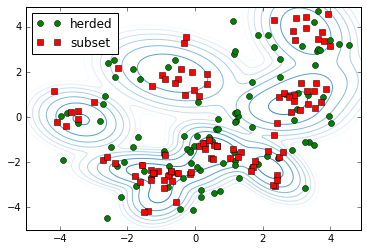

In [16]:
ex.plot()
plt.plot(np.array(herded)[:,0], np.array(herded)[:,1], 'go')
plt.plot(np.array(subsampler.points)[:,0], np.array(subsampler.points)[:,1], 'rs')

plt.legend(['herded', 'subset'], loc='best')

## Compare empirical MMD to random sampling


In [17]:
empirical_MMD_randsample = 0.0
num_trials = 100
for i in xrange(num_trials):
    randsample_features = np.mean(phi(np.array(stream[np.random.randint(0,S,M)])),0)
    randsample_norm = np.dot(randsample_features, randsample_features)
    empirical_MMD_randsample += np.sqrt(full_stream_sq_norm + randsample_norm - 2*np.dot(randsample_features, full_stream_phi))/num_trials
print "empirical MMD randsample (avg of %d):" % num_trials, empirical_MMD_randsample

empirical MMD randsample (avg of 100): 0.0611130794001


In [18]:
herded_features = np.mean(phi(np.array(herded)),0)
herded_norm = np.dot(herded_features, herded_features)
empirical_MMD_herding = np.sqrt(full_stream_sq_norm + herded_norm - 2*np.dot(herded_features, full_stream_phi))
print "empirical MMD herding:", empirical_MMD_herding
print "||u|| = %0.4f, ||v|| = %0.4f, 2<u,v> = %0.4f" % (full_stream_sq_norm, herded_norm, 2*np.dot(herded_features, full_stream_phi))

empirical MMD herding: 0.00710982894695
||u|| = 0.5999, ||v|| = 0.6020, 2<u,v> = 1.2019


In [19]:
subsampled_features = np.mean(phi(np.array(safe_subsampler.points)),0)
subsampled_norm = np.dot(subsampled_features, subsampled_features)
empirical_MMD_online = np.sqrt(full_stream_sq_norm + subsampled_norm - 2*np.dot(subsampled_features, full_stream_phi))
print "empirical MMD online (linear scan):", empirical_MMD_online
print "||u|| = %0.4f, ||v|| = %0.4f, 2<u,v> = %0.4f" % (full_stream_sq_norm, subsampled_norm, 2*np.dot(subsampled_features, full_stream_phi))

empirical MMD online (linear scan): 0.000312036284346
||u|| = 0.5999, ||v|| = 0.6000, 2<u,v> = 1.1999


In [20]:
subsampled_features = np.mean(phi(np.array(subsampler.points)),0)
subsampled_norm = np.dot(subsampled_features, subsampled_features)
empirical_MMD_online = np.sqrt(full_stream_sq_norm + subsampled_norm - 2*np.dot(subsampled_features, full_stream_phi))
print "empirical MMD online (tree search):", empirical_MMD_online
print "||u|| = %0.4f, ||v|| = %0.4f, 2<u,v> = %0.4f" % (full_stream_sq_norm, subsampled_norm, 2*np.dot(subsampled_features, full_stream_phi))

empirical MMD online (tree search): 0.000566241352567
||u|| = 0.5999, ||v|| = 0.5999, 2<u,v> = 1.1998


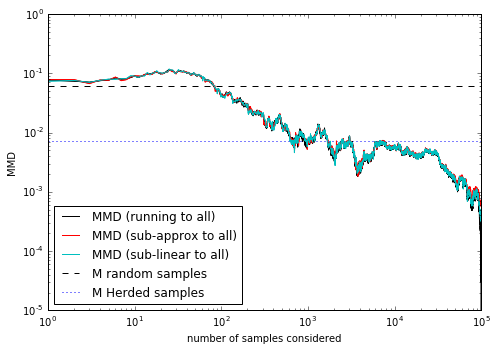

In [21]:
plt.figure(figsize=(7, 5))
plt.loglog(subsampler.MMD_all_gt, 'k')
plt.loglog(subsampler.MMD_sub_gt, 'r')
plt.loglog(safe_subsampler.MMD_sub_gt, 'c')

plt.plot([1,S-1], [empirical_MMD_randsample, empirical_MMD_randsample], 'k--')
plt.plot([1,S-1], [empirical_MMD_herding, empirical_MMD_herding], 'b:')

plt.legend(['MMD (running to all)', 'MMD (sub-approx to all)', 'MMD (sub-linear to all)', 'M random samples', 'M Herded samples'], loc='best')

plt.loglog(subsampler.MMD_all_gt, 'k')
plt.loglog(subsampler.MMD_sub_gt, 'r')
plt.loglog(safe_subsampler.MMD_sub_gt, 'c')

plt.ylim([10e-6, 1])
plt.ylabel('MMD');
plt.xlabel('number of samples considered')
plt.tight_layout(); 

## How well do the selected points estimate test function expectations?

errors from 100 subset points:	
0.00887846885825
0.0480676134301
0.344155689466
0.015589480094

errors from first 100 herding points:	
0.0242765675683
0.107085151268
1.15456922819
0.0497282147613

(average) errors from 100 random samples:	
0.194796334038
0.399866536555
2.1344101128
0.0429126385657

errors from all 100000 random samples:	
0.00787895949709
0.0310559810352
0.126468497674
0.00178551502825


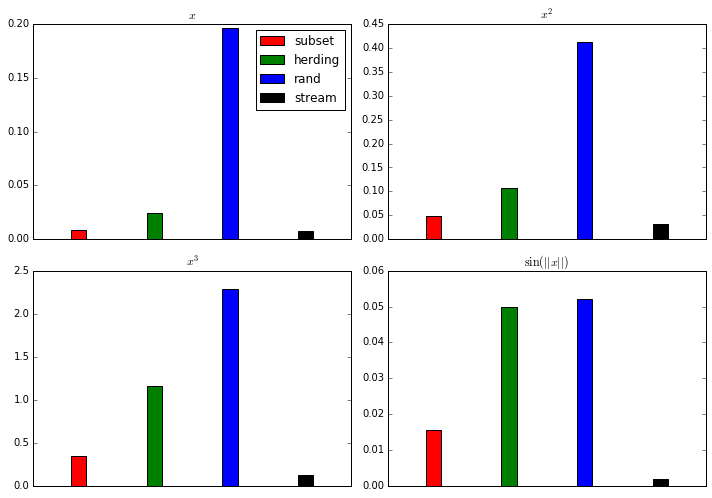

In [22]:
def fn_err(ix, points):
    return np.sqrt(np.mean((E(fns[ix], points) - true_result[ix])**2))

def compute_MSE(output, index):
    squared_error = (np.array(output[index]) - true_result[index])**2
    squared_error = np.mean(squared_error, 1)
    return np.sqrt(squared_error)

def running_mean(x):
    return np.cumsum(x) / np.arange(1,1+len(x))


print "errors from %d subset points:\t" % M
subset_err = [fn_err(ix, np.array(subsampler.points)) for ix in range(len(fns))]
print '\n'.join((map(str, subset_err)))
print "\nerrors from first %d herding points:\t" % M
herding_err = [fn_err(ix, np.array(herded)) for ix in range(len(fns))]
print '\n'.join((map(str, herding_err)))

print "\n(average) errors from %d random samples:\t" % M
randsample_err = np.array([[fn_err(ix, np.array(stream[np.random.randint(0, S, M)])) for ix in range(len(fns))] for i in xrange(100)])
print '\n'.join((map(str, np.median(randsample_err,0))))


print "\nerrors from all %d random samples:\t" % S
stream_err = [fn_err(ix, np.array(stream)) for ix in range(len(fns))]
print '\n'.join((map(str, stream_err)))



plt.figure(figsize=(10,7))
for i in xrange(len(fns)):
    plt.subplot(2,2,i+1)
    plt.bar(-1, subset_err[i], 0.2, color='r')
    plt.bar(0, herding_err[i], 0.2, color='g')
    plt.bar(1, randsample_err[:,i].mean(), width=0.2, color='b')
    plt.bar(2, stream_err[i], 0.2, color='k')
    plt.xticks([])
    plt.xlim([-1.5, 2.7])
    plt.title(fn_labels[i])
    if (i==0): plt.legend(['subset', 'herding', 'rand', 'stream'], loc='best')

plt.tight_layout();

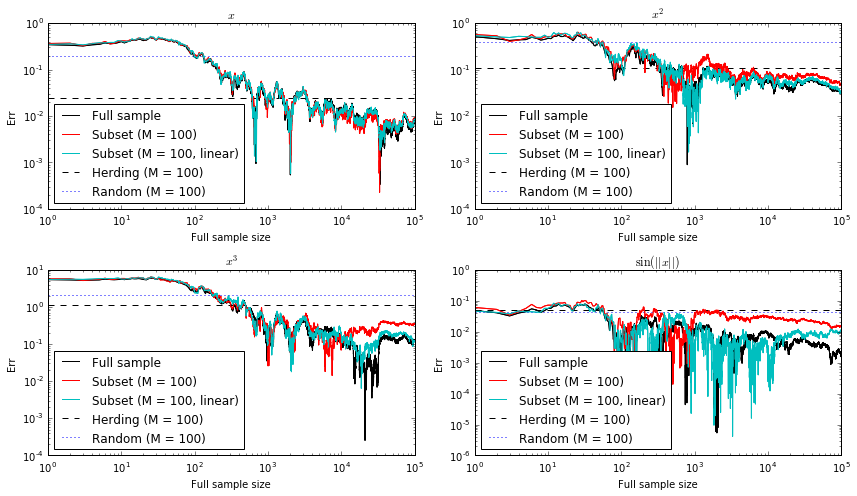

In [23]:
plt.figure(figsize=(12,7))
for i in xrange(len(fns)):
    plt.subplot(2,2,i+1)
    plt.loglog(compute_MSE(subsampler.fn_output_all, i),'k')
    plt.loglog(compute_MSE(subsampler.fn_output_sub, i),'r')
    plt.loglog(compute_MSE(safe_subsampler.fn_output_sub, i),'c')
    plt.plot([1,S], [herding_err[i], herding_err[i]], 'k--')
    plt.plot([1,S], np.median(randsample_err[:,i])*np.ones((2,)), 'b:')
    ylm = plt.ylim()
    if ylm[0] < 1e-6:
        ylm = [1e-6, ylm[1]]
    plt.ylim(ylm)
    plt.legend(['Full sample', 'Subset (M = %d)' % M, 'Subset (M = %d, linear)' % M, 'Herding (M = %d)' % M, 'Random (M = %d)' % M,"M^2 = %d" % (M**2)], loc='best')
    plt.xlabel('Full sample size')
    plt.ylabel('Err')
    plt.loglog(compute_MSE(subsampler.fn_output_all, i),'k')
    plt.loglog(compute_MSE(subsampler.fn_output_sub, i),'r')
    plt.loglog(compute_MSE(safe_subsampler.fn_output_sub, i),'c')
    plt.title(fn_labels[i])
    
plt.tight_layout();